A handful of online encoders are constructed and compared in this post.

## Motivation

I have to encode a large number of strings with integers. The strings are not known in advance for they are coming from a generator. The generator itself takes a list of strings and sanitises them e.g. removes trailing whitespaces.

I try to use generators as much as I can in order to save memory (We are concerned with strings in the order of millions.)

Unfortunately, the encoder utility `LabelEncoder` of `sklearn` has to know all strings in advance. It therefore cannot be used as an online encoder. 

## Random string sequences

We need source of random strings sequences to test the future encoders. Below we write a generator object (or factory), `random_string_sequence_generator_factory` that that yields random string generators. This function can be viewed as an infinite resource of sequence generators. It is really similar to our Markov chain generator [MarkovSequenceGenerator](https://bhornung.github.io/python/2018/09/02/cryptocurrency-names.html).

In [1]:
import random
import string

def random_string_sequence_generator_factory(character_pool,
                                             string_length = 1,
                                             sequence_length = 10):
    """
    Creates a generator or fixed length random string sequences. 
    Please note, this is a generator object that yields a sequence generator.
    
    Parameters:
        character_pool (str) : alphabet
        string_length (int) : length of the random strings
        sequence_length (int) length of the sequence containing random strings
        
    Yields:
        new_generator (generator) : generator of string sequences.
    """
    
    # creates a sequence of random strings
    def sequence_generator(character_pool_, string_length_, sequence_length_):
        """
        Creates a random sequence generator.
        
        We deefine local arguments, to avoid infiltration from outer namespaces.
        In jupyter, it can be a very likely scenario.
        
        Parameters:
            character_pool_ (str) : alphabet
            string_length_ (int) : lenght of the string
            sequence_length_ (int) : length of the sequnce
        Returns:
            sequence (generator) : generator of random string sequence
        """
        
        sequence = (''.join(random.choices(character_pool_, k = string_length_))
                        for idx in range(sequence_length_))
    
        return sequence
    
    # create an infinite resource of generators
    while True:
        new_generator = sequence_generator(character_pool, string_length, sequence_length)
        
        yield new_generator

A generator is created which produces generators of eleven element long sequences of two character random strings.

In [2]:
random_sequence_generator = \
    random_string_sequence_generator_factory('abcdefghijklmnopqrstyuvwxyz',
                                             string_length = 2, 
                                             sequence_length = 11)

Let us consume the first element:

In [3]:
seq_gen1 = next(random_sequence_generator)
print(seq_gen1)

<generator object random_string_sequence_generator_factory.<locals>.sequence_generator.<locals>.<genexpr> at 0x0000027D66FC1BA0>


As we expected a generator object is returned. Now we spend the generator:

In [4]:
print(", ".join(seq_gen1))

ua, fq, wf, uz, cj, yd, ao, qn, xp, ai, vx


Consume more sequences:

In [5]:
for idx in range(7):
    seq_gen = next(random_sequence_generator)
    print("Seq no.: {0}. Sequence: {1}".format(idx, list(seq_gen)))

Seq no.: 0. Sequence: ['ir', 'va', 'nk', 'wk', 'pq', 'wy', 'xq', 'yq', 'rp', 'fc', 'yz']
Seq no.: 1. Sequence: ['mu', 'rr', 'uf', 'nk', 'lz', 'yc', 'jr', 'jk', 'va', 'iy', 'ae']
Seq no.: 2. Sequence: ['xx', 'vw', 'bb', 'ia', 'ms', 'iz', 'yw', 'yu', 'cl', 'qh', 'ph']
Seq no.: 3. Sequence: ['we', 'bc', 'wp', 'dg', 'up', 'fw', 'nu', 'pi', 'bk', 'rj', 'wb']
Seq no.: 4. Sequence: ['ey', 'im', 'vc', 'yg', 'bi', 'lo', 'cw', 'jl', 'yn', 'nw', 'ys']
Seq no.: 5. Sequence: ['zh', 'rj', 'jd', 'nn', 'iz', 'fj', 'kv', 'zm', 'sw', 'vg', 'fp']
Seq no.: 6. Sequence: ['mh', 'qa', 'qy', 'yt', 'ph', 've', 'fg', 'oy', 'ib', 'tb', 'mw']


## Encoders

An encoder takes and object and assigns a unique value to it. It also needs to be consistent. A certain object always associated with the same value.

* initialise lookup table
* obtain object
* look for object in lookup table
* if present 
    * return associated value
* if not
    * create new value
    * save (object, value) pair in lookup table
    * return value

It is clear that an encoder has an associated memory and functions that interact with this memory.

The functions operating on the memory:
* lookup function
* saves pair

We also need a function that can generate unique values. This function has to be aware of the used values and has to implement a rule that generates a new value based on the used ones. The used values can either be exrtacted from the memory (lookup table) or stored in a different memory.

The encoder thus can be defined as a tuple of the following components

* lookup table
* lookup function
* function to generate new value
* function to push (object, value) pair to lookup table
* and at last, function to return value

### List encoder

The first implementation, `_encoder_1` based on the tuple model. We use a list to store the components of the encoder, for tuple are immutable in python.

In [6]:
from itertools import count

_encoder_1_ = [
              {}, 
              count(),
              lambda x: encoder[0].update({x : next(encoder[1])}),
              lambda x: (encoder[2](x), encoder[0][x])[1] 
                            if x not in encoder[0] else encoder[0][x] 
             ]

1. `{}`: the first element of the list is the lookup table, a simple dictionary.


2. `count()`: the second element,  has dual functions.

    * It serves as a memory to store the used values
    * It can provide new values whenever its `next` method is called


3. `encoder[0].update({x : next(encoder[1])})`: the third element  does the following

    * `next(encoder[1])`: creates a new value
    * stores the used values (`count` cannot go backwards)
    * `encoder[0].update({... : ...})`: puhes the (object, value) to the lookup table


4. The fourth element comprises of a manifold steps:
    * it decides whether the object is in the lookup table
    * `else`: if so, 
        *       `encoder[0][x]`: returns the corresponding value `.... else encoder[0][x]`    
    * `if x not in encoder[0]` if not, 
        *       `encoder[2](x)`: creates a new (object, value) pair
        *       saves the new pair
        *       `encoder[0][x]`: retrieves the value from the lookup memory
        *       `(..., ...)[1]`: pushes the value to the user

We would like to make this encoder to be reusable hence it is wrapped in a factory function, `create_encoder_1`

In [7]:
def create_encoder_1():
    _encoder = [
                {}, 
                count(),
                lambda x: _encoder[0].update({x : next(_encoder[1])}),
                lambda x: (_encoder[2](x), _encoder[0][x])[1] 
                              if x not in _encoder[0] else _encoder[0][x] 
               ]
    
    encoder = lambda x: _encoder[3](x)
    
    return encoder

For testing purposes one character long strings are used so that we can see whether the encoding is consistent.

In [8]:
random_sequence_generator_1_10 = \
    random_string_sequence_generator_factory('abcdef',
                                              string_length = 1,
                                              sequence_length = 10)

Let us test our encoder:

In [9]:
encoder_1 = create_encoder_1()
print([(string, encoder_1(string)) 
           for string in next(random_sequence_generator_1_10)])

[('b', 0), ('e', 1), ('b', 0), ('c', 2), ('b', 0), ('b', 0), ('b', 0), ('b', 0), ('b', 0), ('e', 1)]


As we can see the encoding is both unique and consistent. Decoding requires access to the lookup table, which is now hidden because of the convenience $\lambda$-wrapper.

### Function decorator

From a practical point of view, an encoder is a function with an associated memory. If we can associate a storage with a lookup function, we can build an encoder. A convenient tool is a decorator. The `associate_lookup` decorator locks the lookup and used value memories to a function. The function itself `encoder_2` is a dummy. Its only role is to provide acces to the memory. A factory is also created for this encoder.

In [10]:
def associate_lookup(func):
    store = [-1, {}]                         # value, lookup
    
    def lookup_(x):   
        if not x in store[1]:
            store[0] += 1                    # generate unique values
            store[1].update({x : store[0]})  # push new relation to lookup
            
        return store[1][x]                   # push value to user
    
    return lookup_

def create_encoder_2():
    """
    Factory for encoder_2.
    """
    @associate_lookup
    def encoder(x):
        pass
    
    return encoder

We test it on a random one letter sequence:

In [11]:
encoder_2 = create_encoder_2()
print([(string, encoder_2(string)) 
           for string in next(random_sequence_generator_1_10)])

[('f', 0), ('a', 1), ('d', 2), ('a', 1), ('f', 0), ('f', 0), ('e', 3), ('f', 0), ('b', 4), ('c', 5)]


Again, it is unique and consistent. This implementation has a major drawback: the lookup table cannot be accessed, thus the encoded values cannot be decoded. A possible, and rather ugly, solution is to add a decoding table to store. The new function would also require a second argument that specifies which lookup table should be used. This function will not be implemented, for it would only deliver a very modest degree of joy and aesthetic satisfaction.

### Function attributes and decorator

Functions can have user defined attributes. The `associate_explicit_lookup` decorator explicitly bounds the `idx` and `lookup` fields to a function. Both of them are visible to the user.

In [12]:
def associate_explicit_lookup(func):
    
    func.lookup = {}
    func.idx = -1
    
    return func
    
def create_encoder_3():
    
    @associate_explicit_lookup
    def encoder(x):
        
        if not x in encoder.lookup:
            encoder.idx += 1
            encoder.lookup.update({x : encoder.idx})
            
        return encoder.lookup[x]
    
    return encoder

A test confirms below that the encoder works correctly (well, as far as being unique and consistent goes on a small sample).

In [13]:
encoder_3 = create_encoder_3()
print([(string, encoder_3(string)) 
           for string in next(random_sequence_generator_1_10)])

[('f', 0), ('b', 1), ('e', 2), ('c', 3), ('d', 4), ('a', 5), ('e', 2), ('a', 5), ('b', 1), ('c', 3)]


The memory of the function is readily accessible

In [14]:
print("Lookup table: {0}".format(encoder_3.lookup))
print("Number of keys: {0}".format(encoder_3.idx))

Lookup table: {'f': 0, 'b': 1, 'e': 2, 'c': 3, 'd': 4, 'a': 5}
Number of keys: 5


### Encoder class

A classy solution is to bundle the various components of the encoder in form of named fields. A third approach is that of the object oriented programming. (We have been creating object in the previous two implementations too, but in an implicit way.) 

Writing classes has many additional advantages, e.g. maintainable code, adding functionalities, easy manipulation of the underlying fields. The `Encoder` class below implements the encode and decode methods.

In [15]:
class Encoder:
    """
    Lightweight encoder -- decoder class.
    
    Methods:
        encode(x) : returns the code of x
        decode(x) : returns the value that is encoded by x
        reset() : clears memory
    """
    
    def __init__(self):
        
        self._idx = -1
        self._encode_map = {}
        self._decode_map = {}
        
    def encode(self, x):
        """
        Encodes a hashable object with an integer.
        Parameters:
            x (object) : value to encode
            
        Returns:
            (int) code of x
        """
        
        if not x in self._encode_map:
            self._idx += 1
            
            self._encode_map.update({x : self._idx})
            self._decode_map.update({self._idx : x})
            
        return self._encode_map[x]
    
    def decode(self, x):
        """
        Dencodes a hashable object with an integer.
        Parameters:
            x (int) : value to encode
            
        Returns:
            the value that is encoded by x
        """
        return self._decode_map[x]
    
    def reset(self):
        """
        Clears lookup tables.
        """
        
        self._idx = -1
        self._encode_map = {}
        self._decode_map = {}

In [16]:
encoder_4 = Encoder()

# encode
print("Encode:")
print([(string, encoder_4.encode(string)) 
           for string in next(random_sequence_generator_1_10)])

# encode and decode
print("\nEncode -- decode:")
print([(string, encoder_4.decode(encoder_4.encode(string))) 
           for string in next(random_sequence_generator_1_10)])

Encode:
[('e', 0), ('a', 1), ('a', 1), ('d', 2), ('a', 1), ('a', 1), ('a', 1), ('f', 3), ('d', 2), ('f', 3)]

Encode -- decode:
[('f', 'f'), ('a', 'a'), ('f', 'f'), ('e', 'e'), ('a', 'a'), ('f', 'f'), ('c', 'c'), ('e', 'e'), ('f', 'f'), ('c', 'c')]


## Comparison

The performance of the four encoders are compared below. We could have used the [`SimTimer` class](https://github.com/bhornung/SlimTimer/blob/master/slimTimer/slimTimer.py), which also had given opportunities to write more decorators and generators. However, I doubt anyone would debate how refreshing scribbling a few for loops can be.

The string length is eight. The sequence lengths are 100, 1000, 10000, 100000, 1000000. Each size contains five different sequences. 

We do not want to contaminate our mesurements with the time that is needed to generate the random strings, thus they are saved in memory in the 2D list called `test_sequences` in advance.

In [17]:
test_sequences = []
for sequence_length in (100, 1000, 10000, 100000, 1000000):
    rsg = random_string_sequence_generator_factory('abcdefghijklmnopqrtstyuvwxyz',
                                              string_length = 8,
                                              sequence_length = sequence_length)

    test_sequences.extend([list(next(rsg)) for idx in range(10)])

We then collate the encoders with their names in the `encoder_factories` tuple. The second element of the tuple creates a callable encoder.

In [18]:
encoder_factories = (
                     ('encoder_1', create_encoder_1),
                     ('encoder_2', create_encoder_2),
                     ('encoder_3', create_encoder_3),
                     ('encoder_4', lambda: Encoder().encode) # mild lambda abuse
                    )

The `perf_counter` function of of the `time` module will mesaure the execution time. The variables are collected in the `results` list of tuples.

In [20]:
import time

# store execution times
results = []

# loop over arrays
for seq in test_sequences:
    
    # loop over encoders
    for name, factory in encoder_factories:
        # create decoder
        encoder = factory()
        # measure execution time
        tstart = time.perf_counter()
        
        _ = [encoder(x) for x in seq]
            
        tend = time.perf_counter() 
        tdelta = tend - tstart
        
        results.append((name, len(seq), tdelta))

The results are easily processed by a few pandas operations. Alternatively, one can use `seaborn`.

In [21]:
import pandas as pd

results_df = pd.DataFrame(results, columns = ['type', 'size', 'time'])
stats_df = results_df.groupby(['type', 'size']).describe()['time'][['mean', 'std']]
stat_groups_df = stats_df.groupby(level = 0)

The mean execution times are then plotted against the sequence size along with the standard deviation. (The deviations are barely visible.)

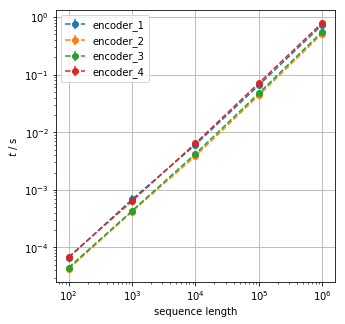

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('sequence length'); ax.set_ylabel(r'$t$ / s')
ax.grid(True)

for name, data in stat_groups_df:
    x = data.index.get_level_values(1)
    ax.errorbar(x, data['mean'], yerr = data['std'], 
                fmt = '--o',  label = name)
    
    ax.legend()
plt.show()

There is not a tremendous difference between the various encoders. The class and tuple implementations are approximately 20% slower than the ones using decorators. The choice of method therefore the class implementation.